# LeNet konvolúciós neurális hlózat alapú klasszifikáció

* Saját modell definiálása, betanítása
* CIFAR-10 adathalmazon történő tanítás és tesztelés

In [1]:
# szükséges python csomagok importálása

import torch.nn as nn
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# cuda hasznalata rendelkezésre állás esetén a gyorsabb számításokért
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# LeNet CNN modell osztály létrehozása, rétegek meghatározása

class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()

        self.feature_extr = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.AvgPool2d(2, 2)
        )

        self.fc1 = nn.Linear(13456, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.fc_act = nn.ReLU()

    def forward(self, x):
        x = self.feature_extr(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc_act(x)
        x = self.fc2(x)
        x = self.fc_act(x)
        x = self.fc3(x)
        return x

In [3]:
# saját modell létrehozása

model = LeNet()

In [4]:
# veszteségfüggvény (CrossEntropy) és gradiens frissítő (Adam) eljárások meghatározása

criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [5]:
# tanítóciklus létrehozása címkézett adatok alapján

def train(train_loader):
    total, correct = 0, 0
    total_loss = 0

    model.train()

    for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs.to(device)
        labels.to(device)
        y_pred = model.forward(imgs)
        loss = criterion(y_pred, labels)

        loss.backward()
        optim.step()
        optim.zero_grad()

        total_loss = loss.item()

        _, predicted = torch.max(y_pred, 1)
        total += labels.size(0)

        correct += (predicted == labels).sum().item()

    accuracy = (correct / total) * 100
    epoch_loss = total_loss / total
    return accuracy, epoch_loss

In [6]:
# kiértékelési függvény meghatározása (teszt adathalmazon)

def eval_own_model(test_loader):
    total, correct = 0, 0
    for batch_idx, (imgs, labels) in enumerate(test_loader):
        imgs.to(device)
        labels.to(device)
        y_pred = model.forward(imgs)

        _, predicted = torch.max(y_pred, 1)
        total += labels.size(0)

        correct += (predicted == labels).sum().item()

        if batch_idx % 100 == 0:
            print(f"running accuracy: {correct / total * 100}")

    return 100 * ( correct / total)

In [7]:
# tanító / teszt képeken végzett transzformációk meghatározása
# CIFAR-10 adathalmaz letöltése (train és test DataLoader objektumok)

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomInvert(0.5),
    transforms.RandomHorizontalFlip(p=0.6),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.6, contrast=0.8),
    transforms.ToTensor(),
    transforms.GaussianBlur(3, (0.1, 1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])


# adatok letöltése
train_data = datasets.CIFAR10("data/cifar10", train=True, transform=train_transform, download=True)
test_data = datasets.CIFAR10("data/cifar10", transform=test_transform, train=False, download=True)


# feldolgozás batchekben
train_loader = DataLoader(
    dataset=train_data,
    batch_size=16,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_data,
    batch_size=16,
    shuffle=False
)


100%|██████████| 170M/170M [00:04<00:00, 41.4MB/s]


In [8]:
# tanítóckilus definiálása
# 10 epochon keresztül

# későbbi vizualizációra szükségesek
acc_list = []
loss_list = []

for i in range(10):
    running_acc, running_loss = train(train_loader)
    acc_list.append(running_acc)
    loss_list.append(running_loss)
    print(f"epoch {i+1} done")

epoch 1 done
epoch 2 done
epoch 3 done
epoch 4 done
epoch 5 done
epoch 6 done
epoch 7 done
epoch 8 done
epoch 9 done
epoch 10 done


running accuracy: 81.25
running accuracy: 55.383663366336634
running accuracy: 54.69527363184079
running accuracy: 55.087209302325576
running accuracy: 54.738154613466335
running accuracy: 54.79041916167665
running accuracy: 55.022878535773714


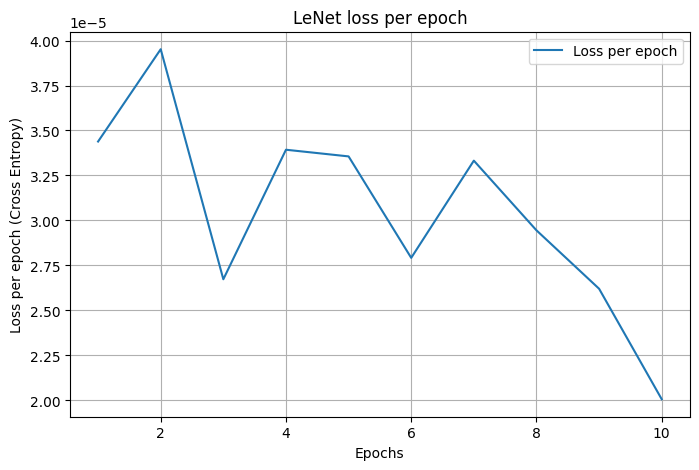

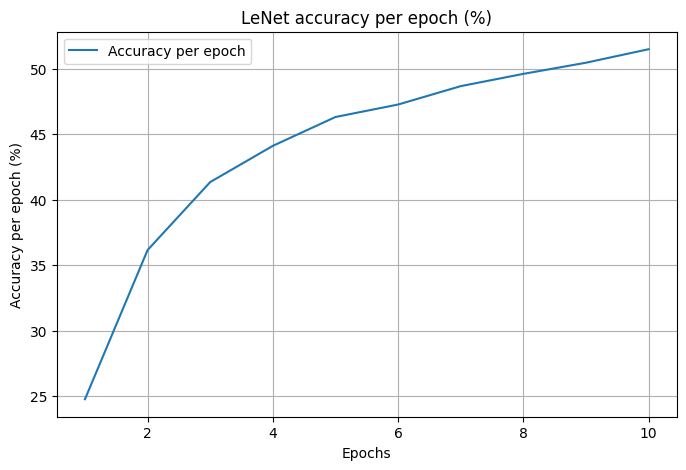

Final LeNet Accuracy on CIFAR-10: 55.07%


In [9]:
## pontosság kiiratása, vizualizáció (tanulás során mért pontosságból)

def show_lenet_accuracy(accuracy_list: list):
    epoch_list = range(1, len(accuracy_list) + 1)
    plt.figure(figsize=(8,5))
    plt.plot(epoch_list, accuracy_list, label="Accuracy per epoch")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy per epoch (%)')
    plt.title("LeNet accuracy per epoch (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

def show_lenet_loss(loss_list: list):
    epoch_list = range(1, len(loss_list) + 1)
    plt.figure(figsize=(8,5))
    plt.plot(epoch_list, loss_list, label="Loss per epoch")
    plt.xlabel('Epochs')
    plt.ylabel('Loss per epoch (Cross Entropy)')
    plt.title("LeNet loss per epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

accuracy = eval_own_model(test_loader)

show_lenet_loss(loss_list)
show_lenet_accuracy(acc_list)

print(f"Final LeNet Accuracy on CIFAR-10: {accuracy:.2f}%")
